In [3]:
import wandb

import os
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch

from PIL import Image
from dataset import get_learn_data, save_datasets
from topo_image import TopoImage
from models import BasicAutoEncoder, ModifiedAutoEncoder, UNet
from train import fit
from predict import make_prediction
from metrics import evaluate_model
from utils import set_random_seed, init_weights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!wandb login

wandb: Currently logged in as: volodin-daniil. Use `wandb login --relogin` to force relogin


In [5]:
RANDOM_SEED = 42

# CRACK500

## Data

### Generate Data

In [36]:
set_random_seed(RANDOM_SEED)

noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=15, min_width=50, max_height=30, max_width=150, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=50, min_width=15, max_height=150, max_width=30, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=15, min_width=50, max_height=30, max_width=150, fill_value=0, p=0.7),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=50, min_width=15, max_height=150, max_width=15, fill_value=0, p=0.7)
])

train_loader, val_loader, test_loader = get_learn_data("data/Roads/tiff", "train_labels", "val_labels", "test_labels", 
                                                       noise_transformations=noise_transformations, patch_mode="split",
                                                       patch_size=(300, 300), img_size=(1500, 1500), batch_size=32, filter_empty=False)

save_datasets("data/Roads/patches_300/", [train_loader, val_loader, test_loader], ["train", "val", "test"])


100%|██████████| 39/39 [01:19<00:00,  2.03s/it]


In [140]:
set_random_seed(RANDOM_SEED)

train_loader, val_loader, test_loader = get_learn_data("data/Roads/patches_300", "train_gt", "val_gt", "test_gt", 
                                                       "train", "val", "test", noise_transformations=noise_transformations, 
                                                       patch_mode="resize", patch_size=(60, 60), img_size=(300, 300), batch_size=32, filter_empty=False)

save_datasets("data/Roads/patches_60/", [train_loader, val_loader, test_loader], ["train", "val", "test"], filter_empty=True)

100%|██████████| 39/39 [00:06<00:00,  5.77it/s]


### Load Data

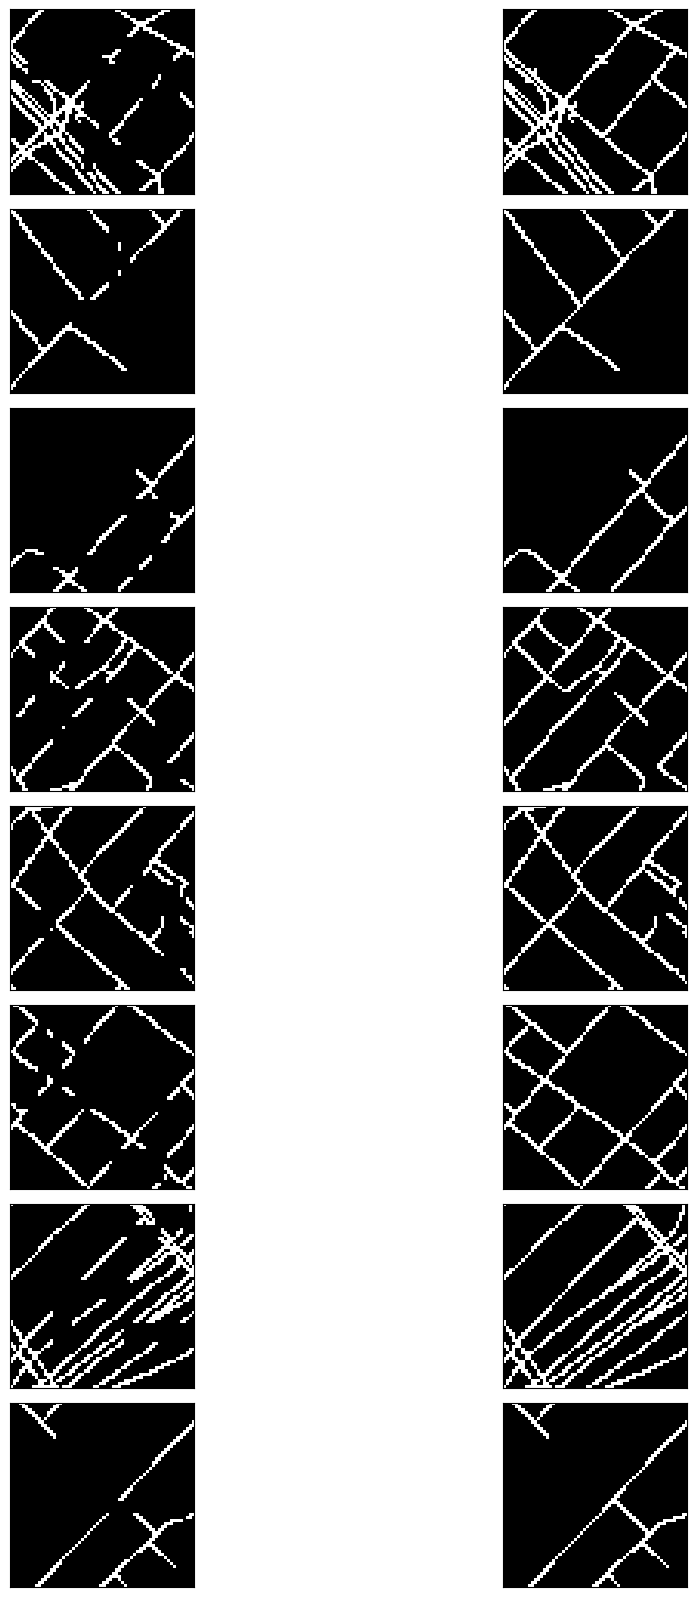

In [46]:
set_random_seed(RANDOM_SEED)

noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=3, min_width=10, max_height=6, max_width=30, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=10, min_width=3, max_height=30, max_width=6, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=3, min_width=10, max_height=6, max_width=30, fill_value=0, p=0.7),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=10, min_width=3, max_height=30, max_width=6, fill_value=0, p=0.7)
])

train_loader, val_loader, test_loader = get_learn_data("data/Roads/patches_60", "train_gt", "val_gt", "test_gt", 
                                                       "train", "val", "test", noise_transformations=noise_transformations, 
                                                       patch_mode="keep", img_size=(60, 60), batch_size=32, max_size=2500)

fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    noised_image, gt_image, img_name, patch_num = val_loader.dataset[idx + 30]

    # noised input
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_image), cmap='grey')

    # gt image
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_image), cmap='grey')

    fig.tight_layout()
plt.show()

In [142]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(2500, 325, 1031)

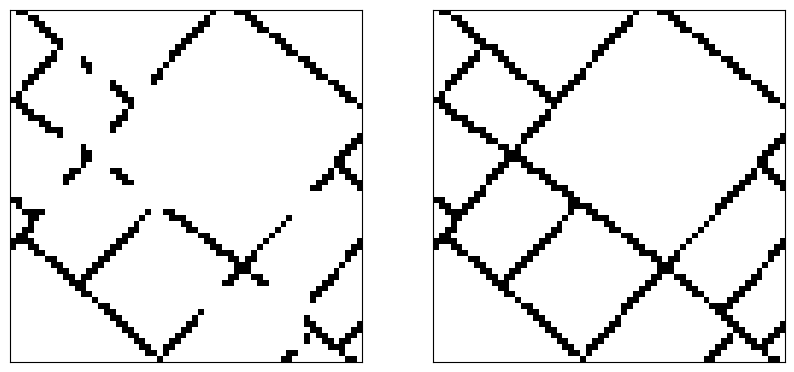

In [143]:
gt_img =  val_loader.dataset[35][1]
noised_img =  val_loader.dataset[35][0]

fig = plt.figure(figsize=(10, 32))

ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(1 - noised_img), cmap='grey')

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(np.squeeze(1 - gt_img), cmap='grey')

plt.show()

In [144]:
TopoImage(gt_img).betti_numbers()

[2, 3, 0]

In [145]:
TopoImage(noised_img).betti_numbers()

[13, 0, 0]

## BasicAutoEncoder

### Only BCELoss

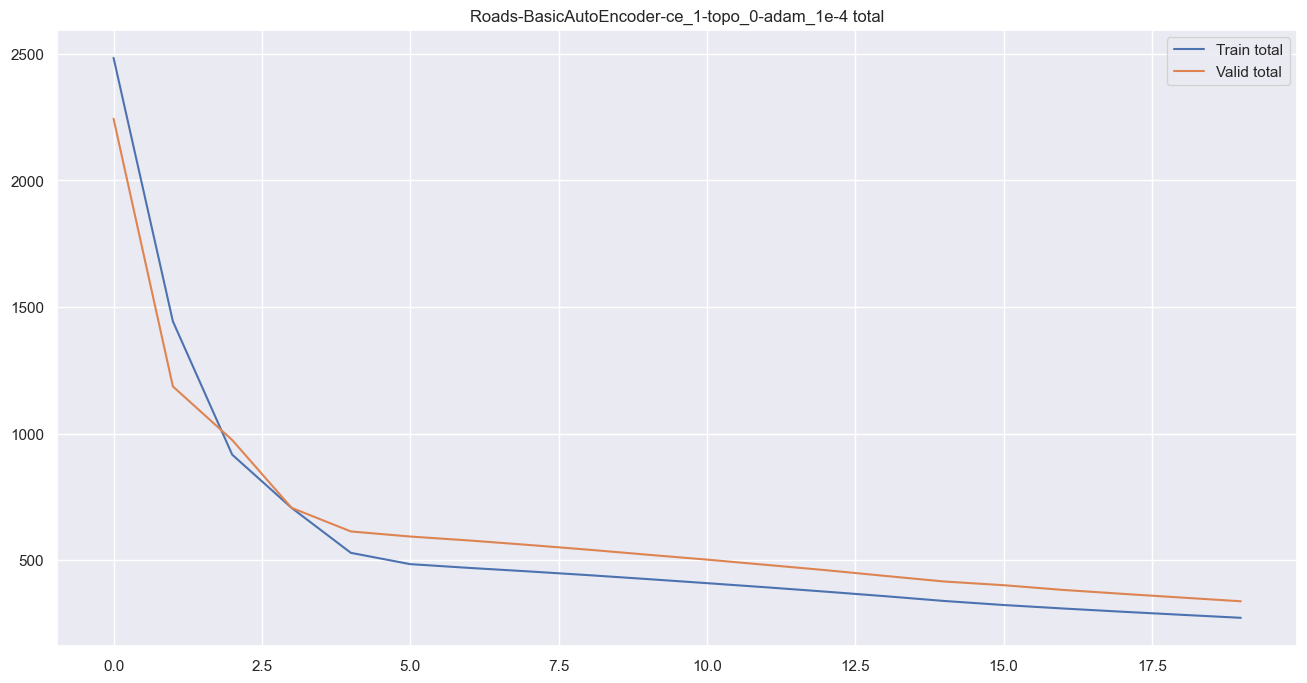

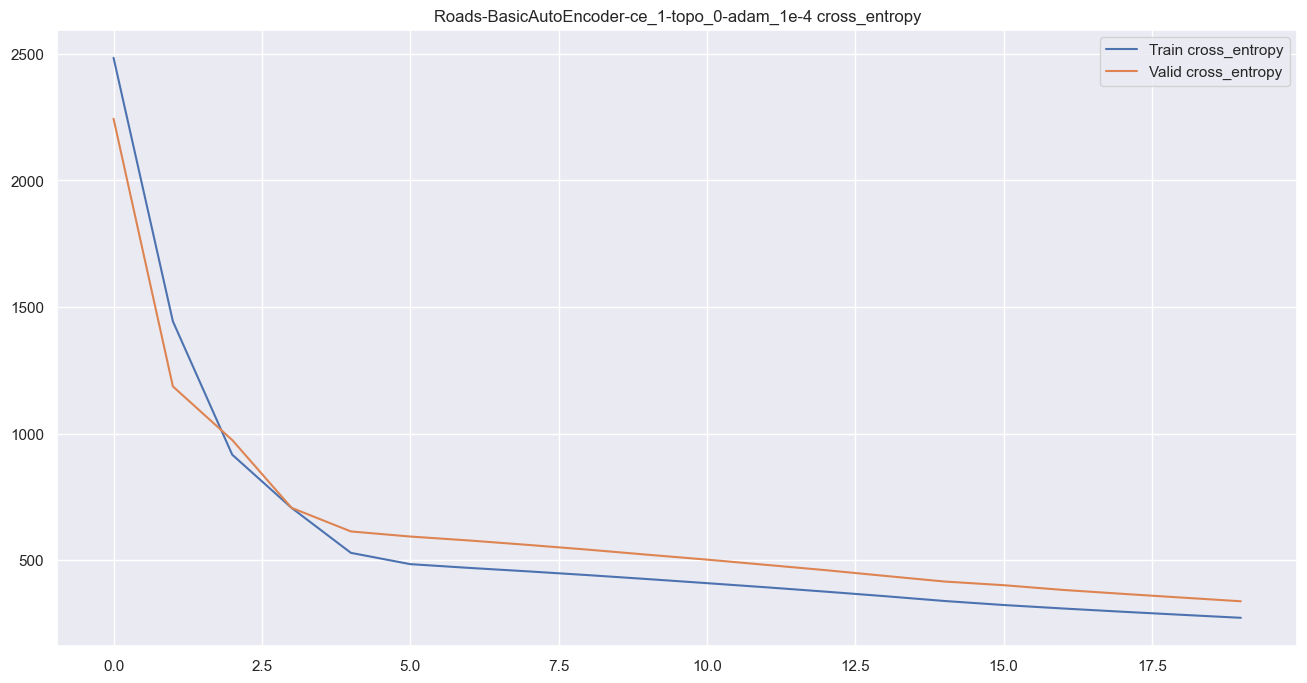

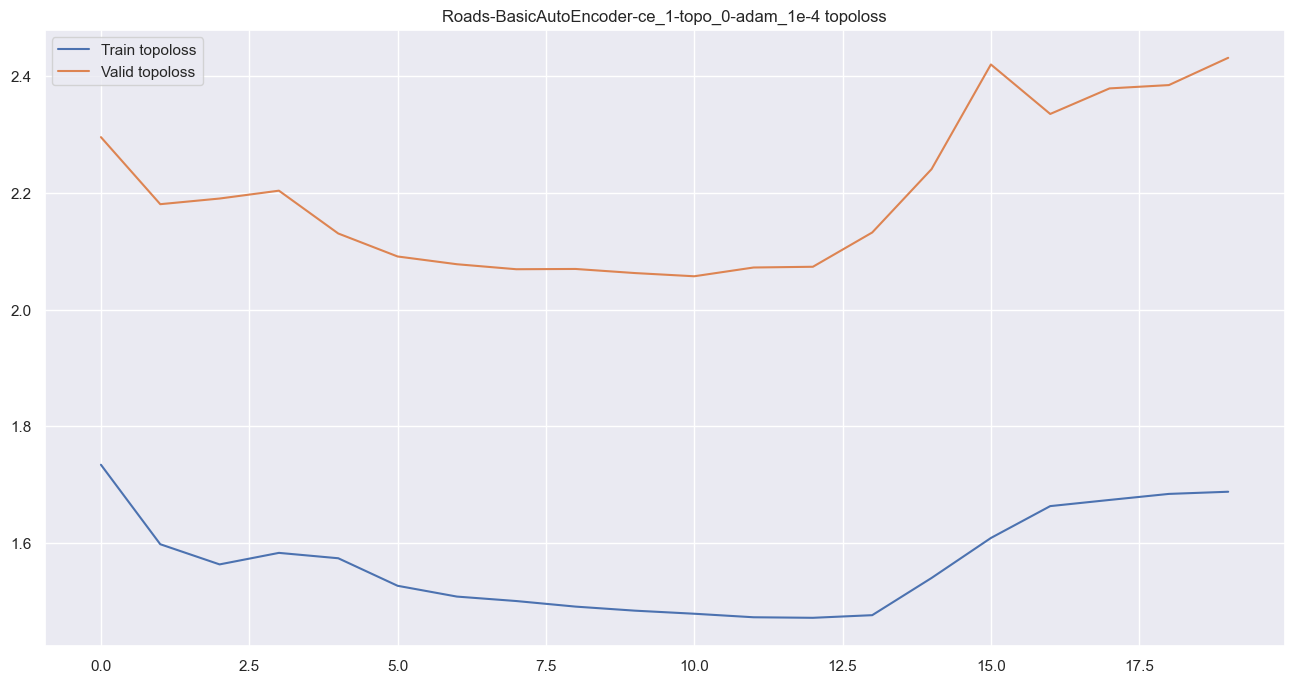

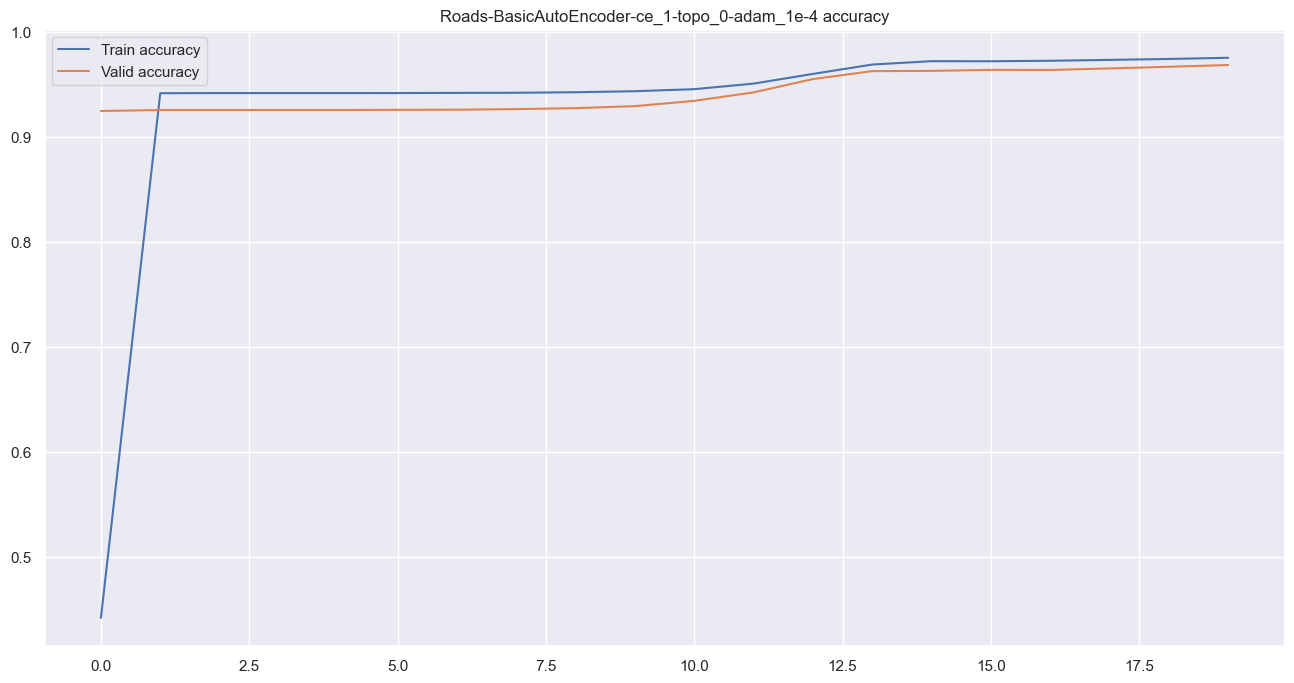

Epoch 19
 train loss: {'total': 271.7054712402344, 'cross_entropy': 271.7054712402344, 'topoloss': 1.688067963027954}, train metrics: {'accuracy': 0.9755115622520447}
 val loss: {'total': 337.04727839543267, 'cross_entropy': 337.04727839543267, 'topoloss': 2.4311477499741776}, val metrics: {'accuracy': 0.9686367489741399, 'betti_number_error': 7.72, 'betti_number_error_0': 5.32923076923077, 'betti_number_error_1': 2.390769230769231}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001


In [148]:
config = dict(
    net="BasicAutoEncoder",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=64,
    epochs=20,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

100%|██████████| 33/33 [00:33<00:00,  1.00s/it]


{'accuracy': 0.9772645310217841, 'betti_number_error': 5.166828322017459, 'betti_number_error_0': 3.8903976721629485, 'betti_number_error_1': 1.2764306498545102}


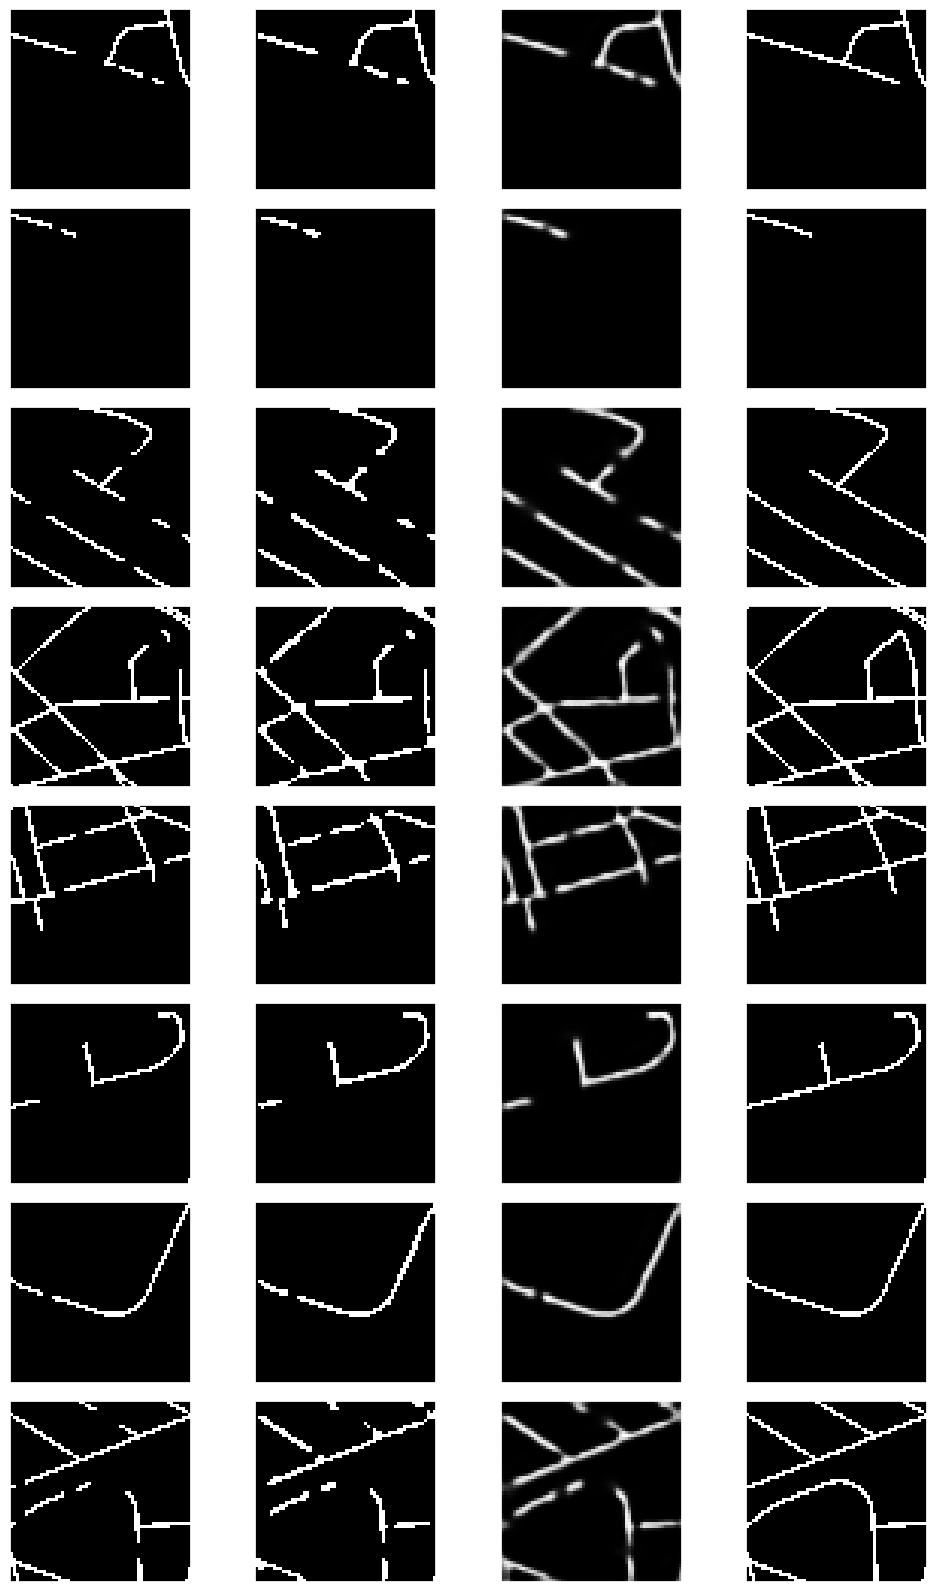

In [149]:
results_1, results_probs_1 = evaluate_model(net, test_loader, device)

### 1-e3 * BCELoss + TopoLoss

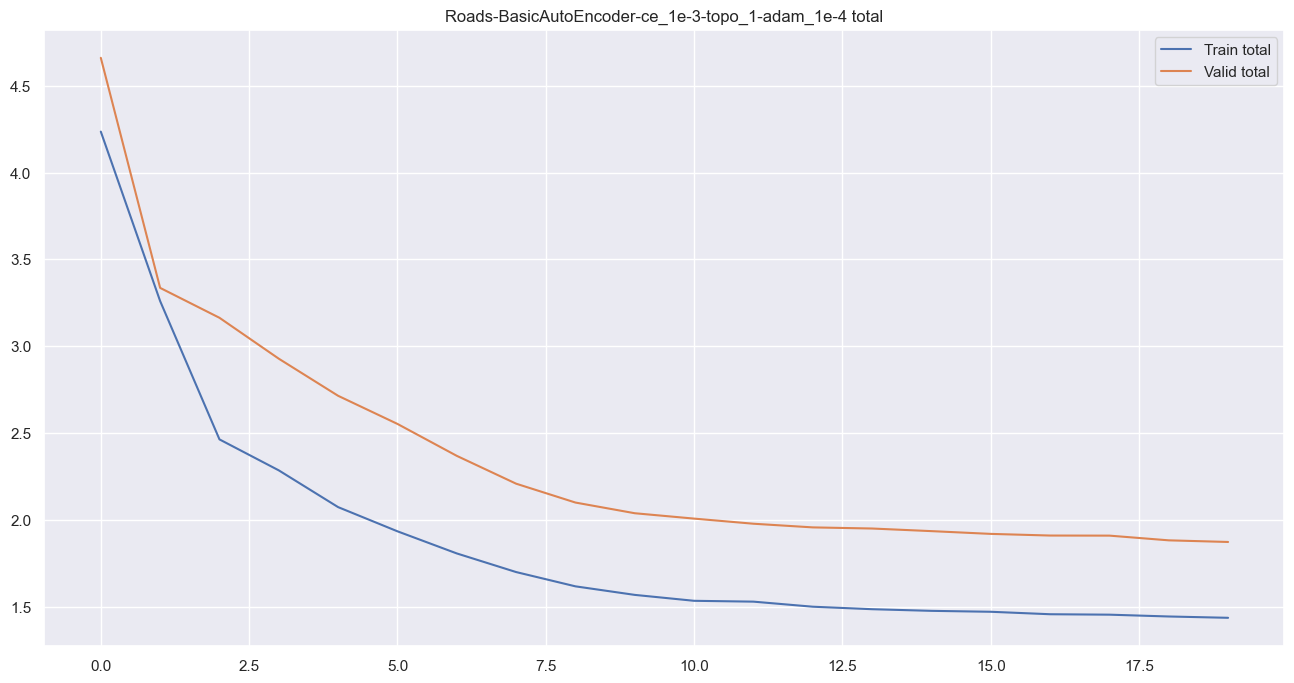

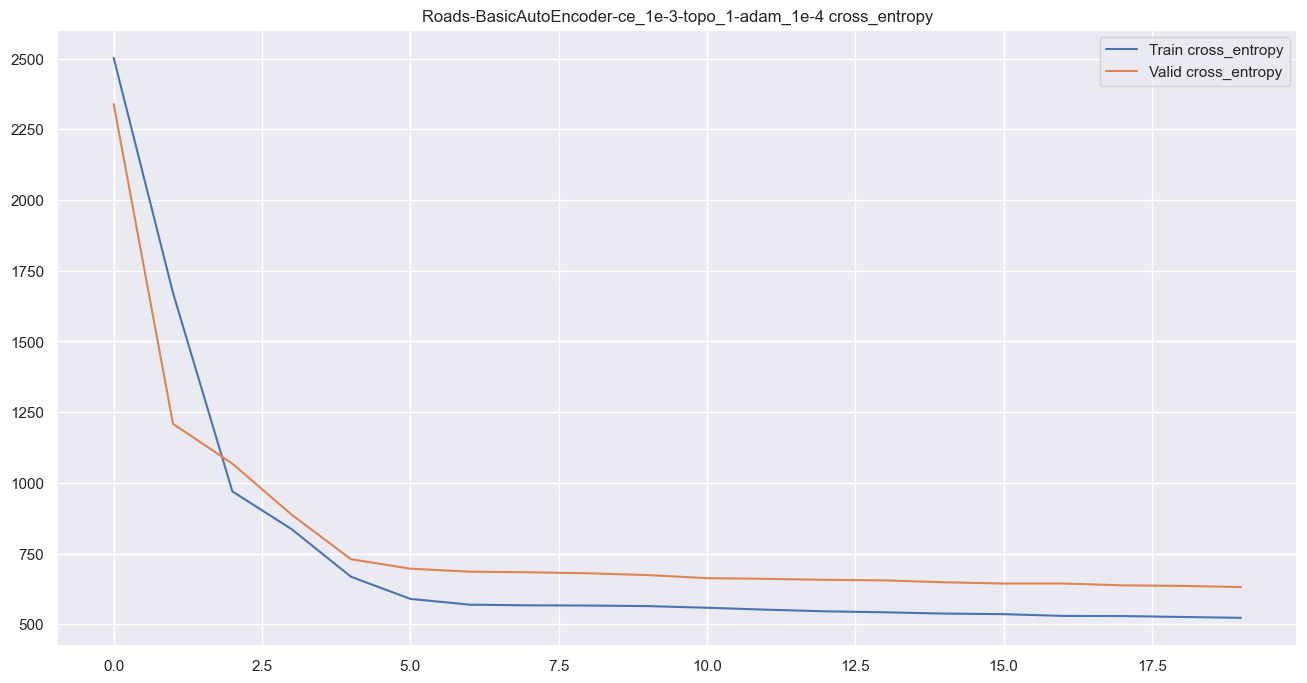

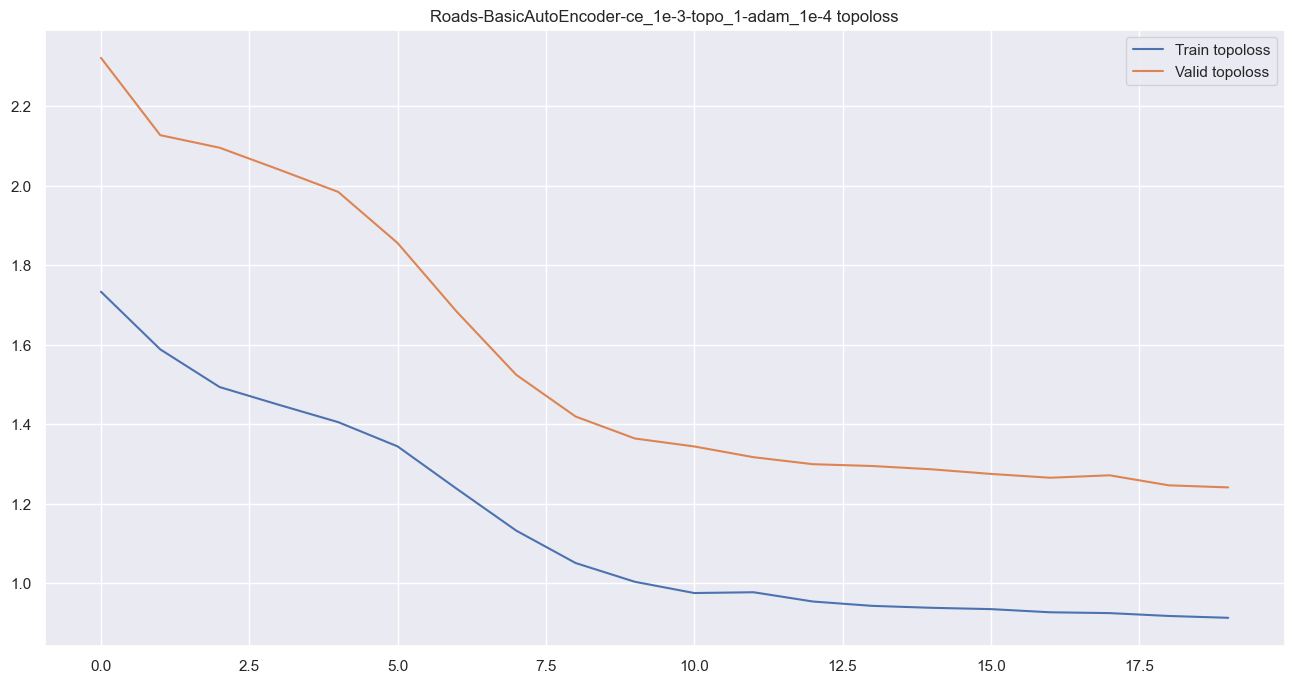

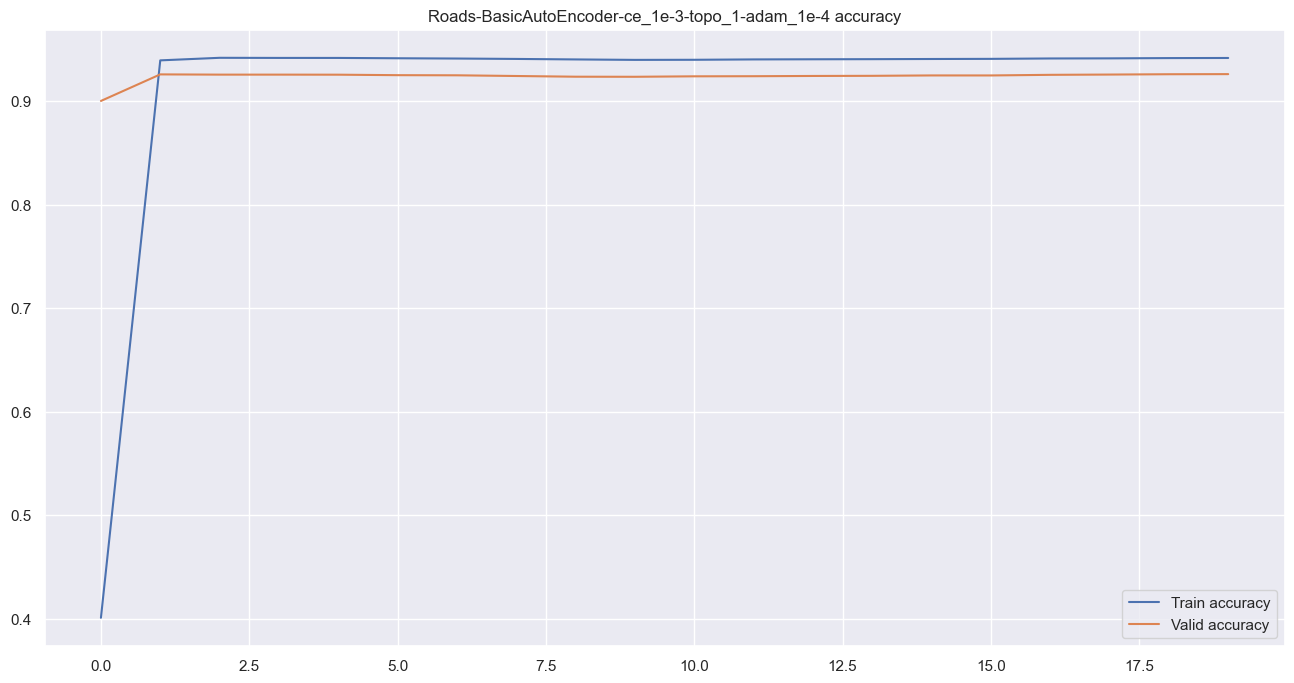

Epoch 19
 train loss: {'total': 1.4352128616333009, 'cross_entropy': 522.7588747070313, 'topoloss': 0.9124539658546448}, train metrics: {'accuracy': 0.941647887802124}
 val loss: {'total': 1.8720301246643067, 'cross_entropy': 631.425947265625, 'topoloss': 1.2406041431427002}, val metrics: {'accuracy': 0.9260521404559796, 'betti_number_error': 7.71076923076923, 'betti_number_error_0': 3.123076923076923, 'betti_number_error_1': 4.587692307692308}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001


In [150]:
config = dict(
    net="BasicAutoEncoder",
    dataset="Roads",
    lambda_ce=1e-3,
    lambda_topo=1,
    batch_size=64,
    epochs=20,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1e-3-topo_1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

100%|██████████| 33/33 [00:33<00:00,  1.02s/it]


{'accuracy': 0.9436485556927153, 'betti_number_error': 4.475266731328807, 'betti_number_error_0': 2.248302618816683, 'betti_number_error_1': 2.2269641125121242}


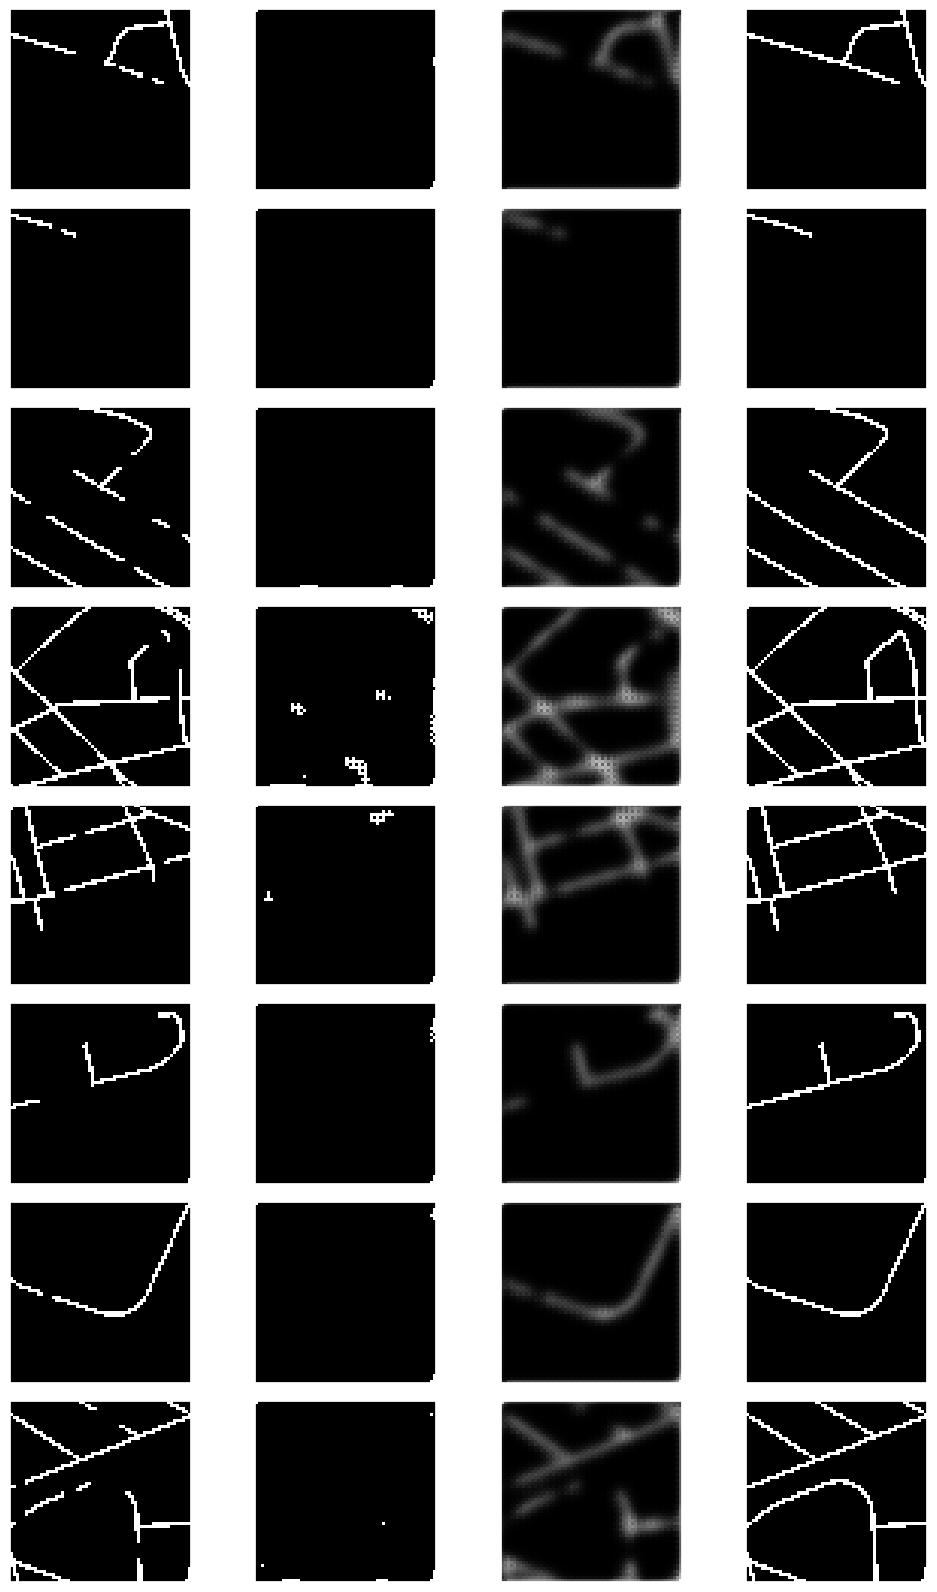

In [151]:
results_2, results_probs_2 = evaluate_model(net, test_loader, device)

100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


{'accuracy': 0.9028144174126256, 'betti_number_error': 4.950533462657614, 'betti_number_error_0': 3.279340446168768, 'betti_number_error_1': 1.6711930164888458}


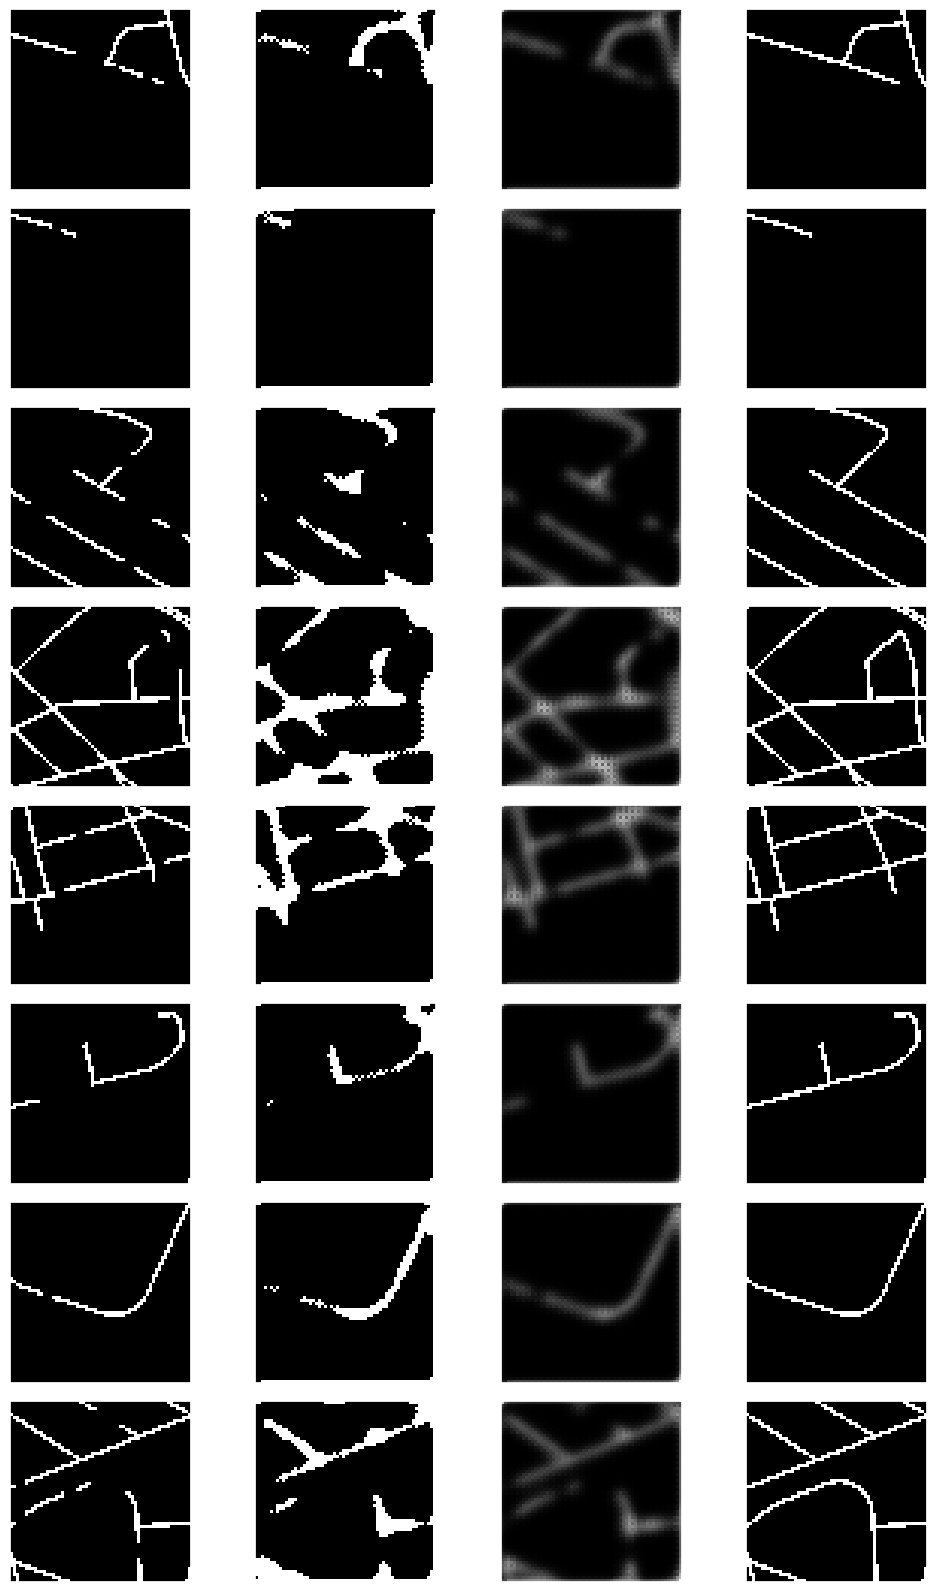

In [153]:
results_2_2, results_probs_2_2 = evaluate_model(net, test_loader, device, threshold=0.2)

## U-Net

### Only BCELoss

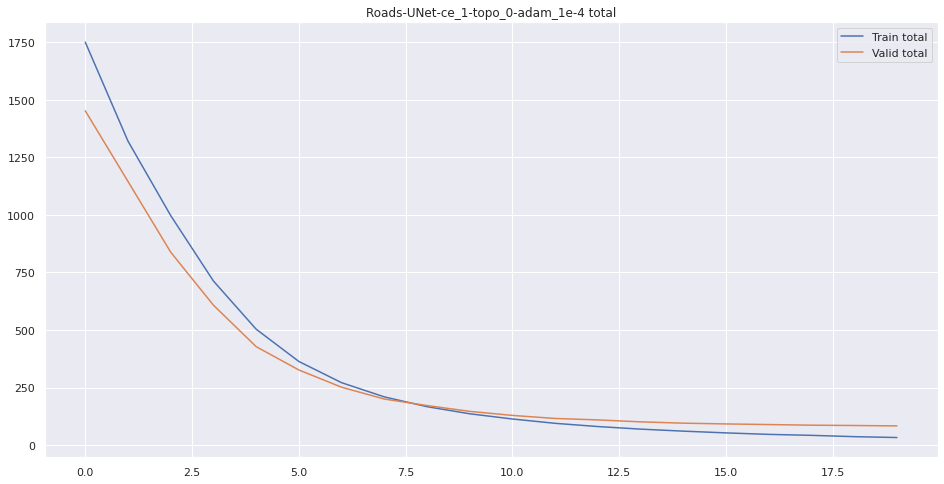

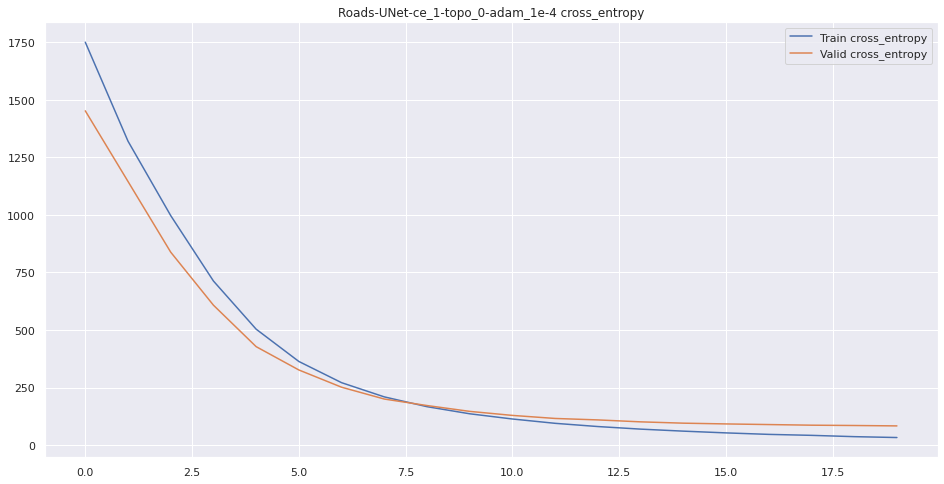

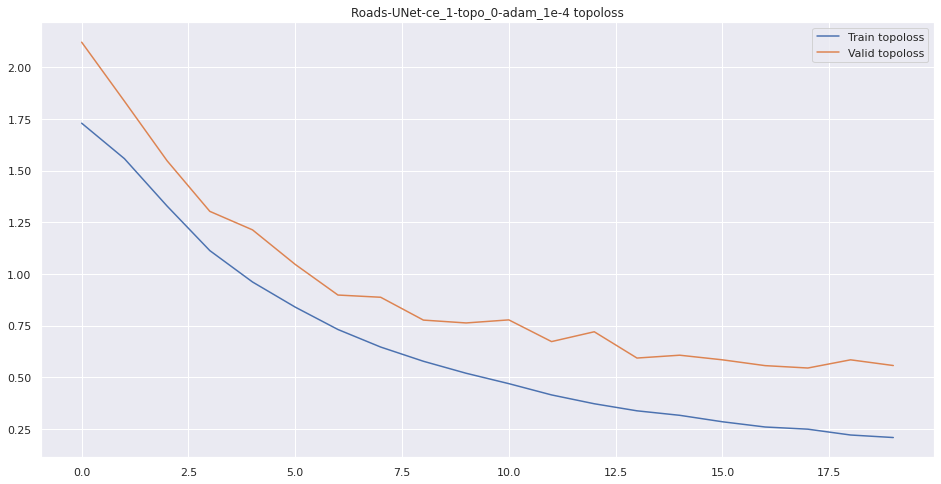

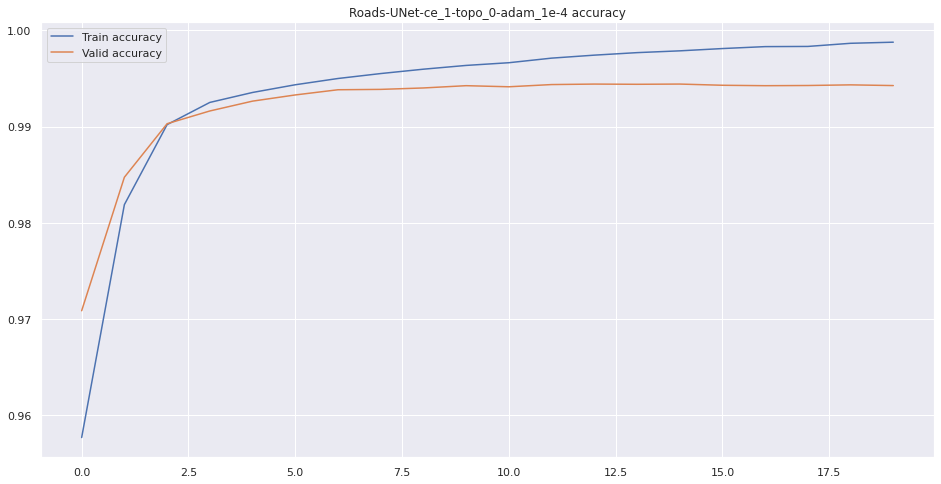

Epoch 19
 train loss: {'total': 32.7688039855957, 'cross_entropy': 32.7688039855957, 'topoloss': 0.20877056250572204}, train metrics: {'accuracy': 0.9987824640274048}
 val loss: {'total': 83.32999802809495, 'cross_entropy': 83.32999802809495, 'topoloss': 0.5571977505317101}, val metrics: {'accuracy': 0.9942718095045824, 'betti_number_error': 1.2276923076923076, 'betti_number_error_0': 0.6707692307692308, 'betti_number_error_1': 0.556923076923077}



wandb:                                                                                
wandb: 
wandb: Run history:
wandb: lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: lr 0.0001
wandb: 
wandb: 🚀 View run Roads-UNet-ce_1-topo_0-adam_1e-4 at: https://wandb.ai/volodin-daniil/topological-autoencoder/runs/yuv48hk6
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240511_015340-yuv48hk6/logs


In [ ]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=64,
    epochs=20,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [ ]:
torch.save(net.state_dict(), "models/unet_bce.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:32<00:00,  1.00it/s]


{'accuracy': 0.9956870240915411, 'betti_number_error': 0.8137730358874878, 'betti_number_error_0': 0.5266731328806984, 'betti_number_error_1': 0.2870999030067895}


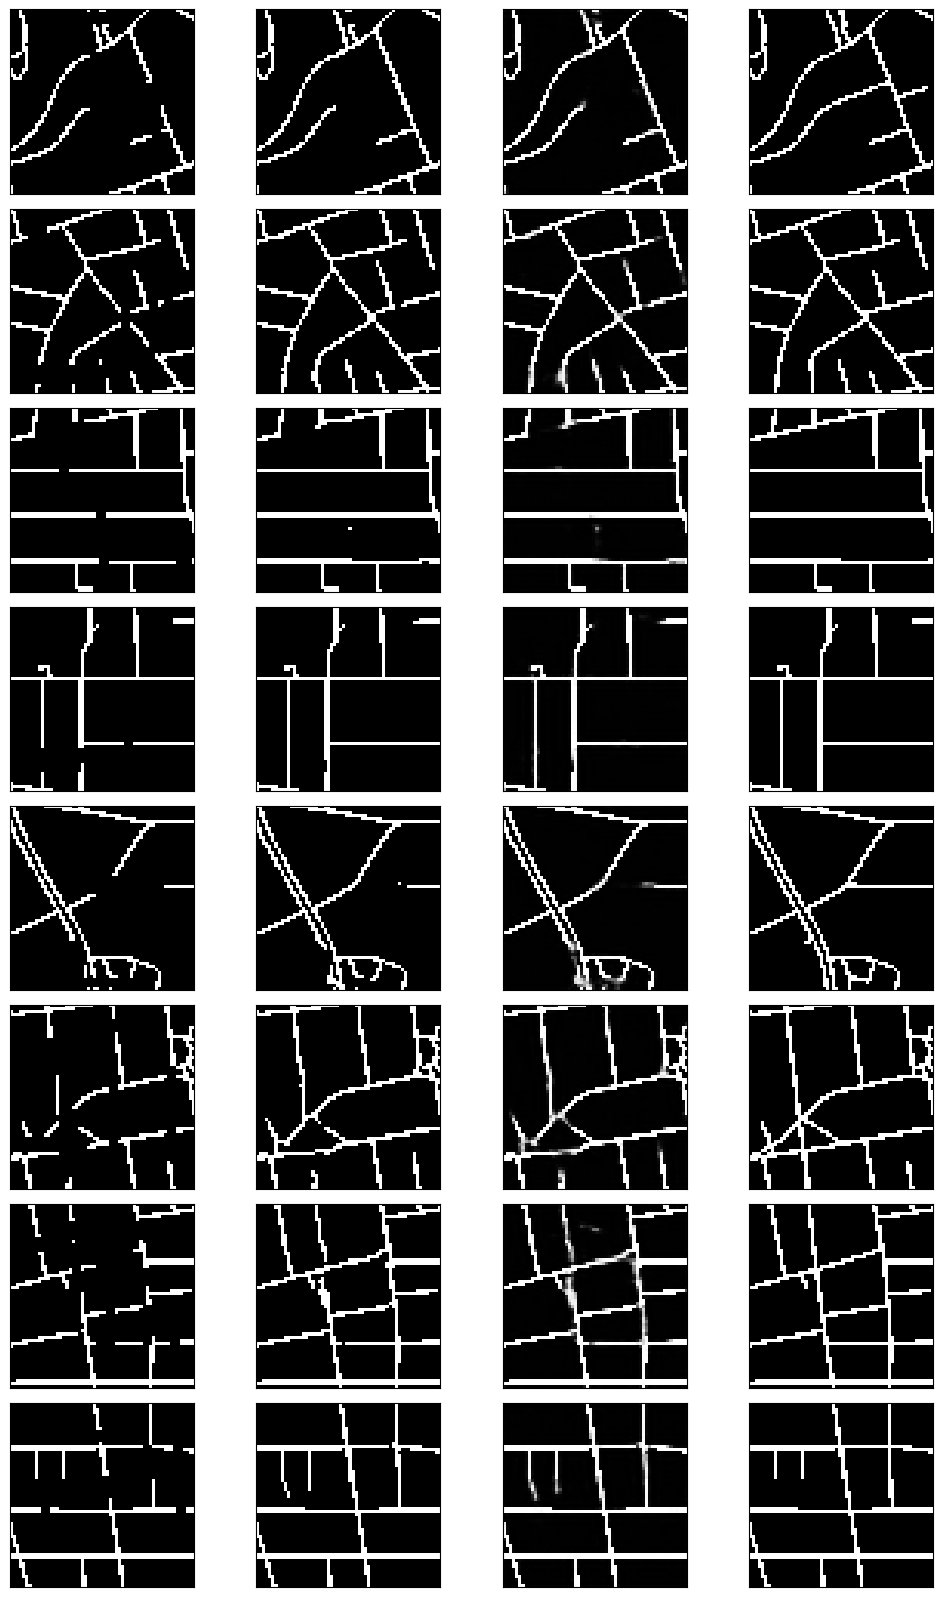

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = UNet()
net.load_state_dict(torch.load("models/unet_bce.pt", map_location=device))
results_unet_1, results_probs_unet_1 = evaluate_model(net, test_loader, device, start_ind=680)

### 1-e3 * BCELoss + TopoLoss

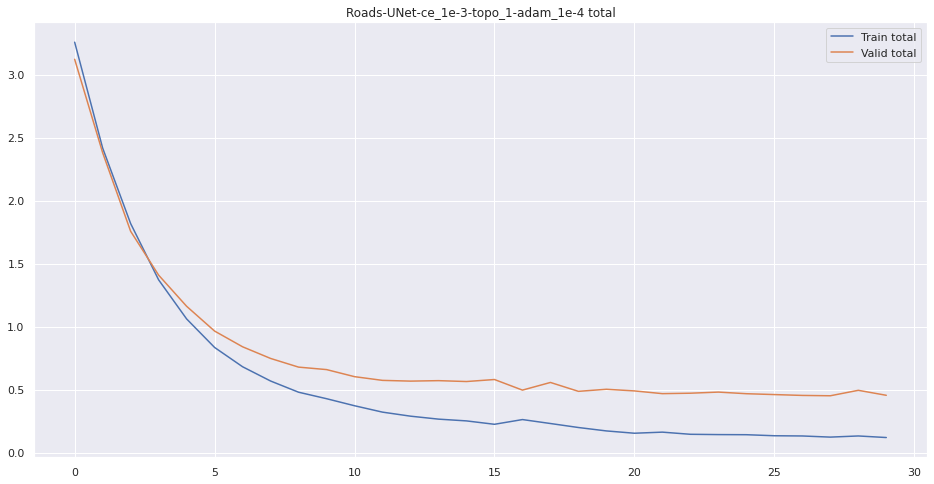

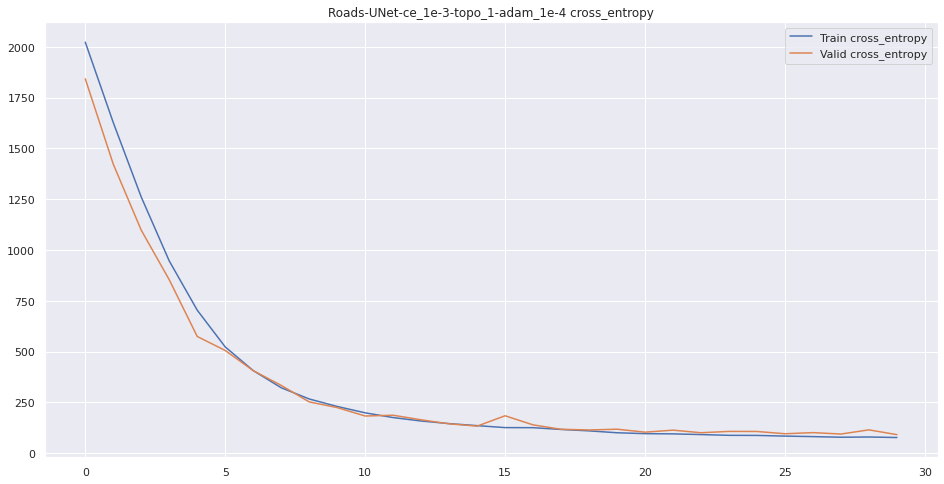

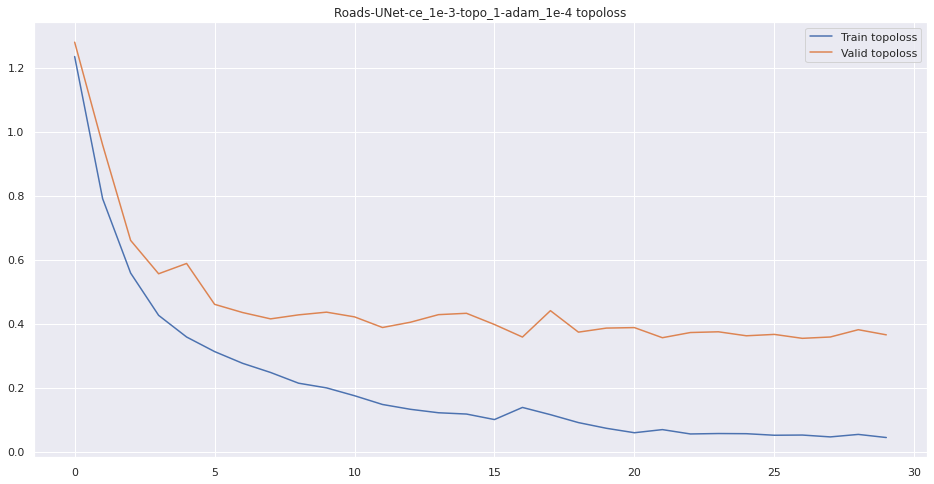

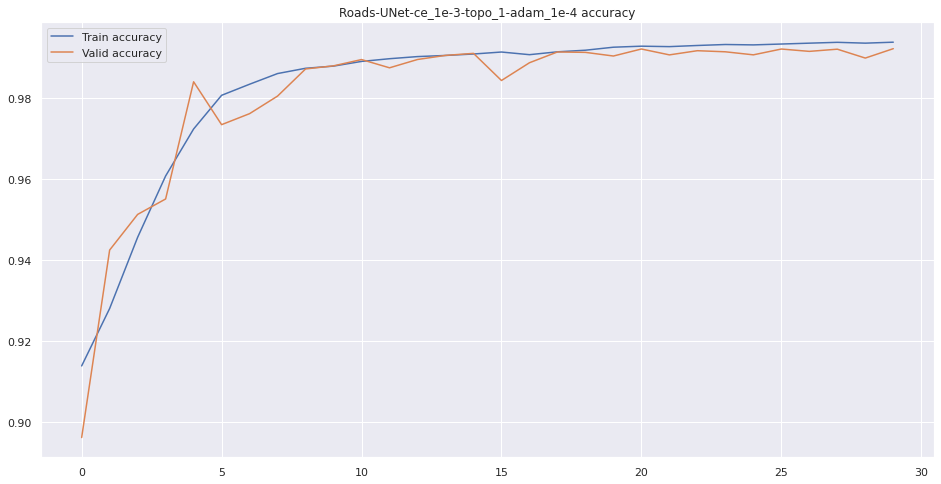

Epoch 29
 train loss: {'total': 0.1205013835310936, 'cross_entropy': 76.38296657714844, 'topoloss': 0.04411841334104538}, train metrics: {'accuracy': 0.9937920246124268}
 val loss: {'total': 0.4556710753074059, 'cross_entropy': 90.6039034329928, 'topoloss': 0.3650671709500826}, val metrics: {'accuracy': 0.99219147168673, 'betti_number_error': 0.7723076923076924, 'betti_number_error_0': 0.36, 'betti_number_error_1': 0.4123076923076923}



wandb:                                                                                
wandb: 
wandb: Run history:
wandb: lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: lr 0.0001
wandb: 
wandb: 🚀 View run Roads-UNet-ce_1e-3-topo_1-adam_1e-4 at: https://wandb.ai/volodin-daniil/topological-autoencoder/runs/f8rk8kgb
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240511_041135-f8rk8kgb/logs


In [ ]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1e-3,
    lambda_topo=1,
    batch_size=64,
    epochs=30,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1e-3-topo_1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [ ]:
torch.save(net.state_dict(), "models/unet_bce_1e-3_topo_1.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:34<00:00,  1.06s/it]


{'accuracy': 0.9942348278574754, 'betti_number_error': 0.4539282250242483, 'betti_number_error_0': 0.23084384093113483, 'betti_number_error_1': 0.22308438409311349}


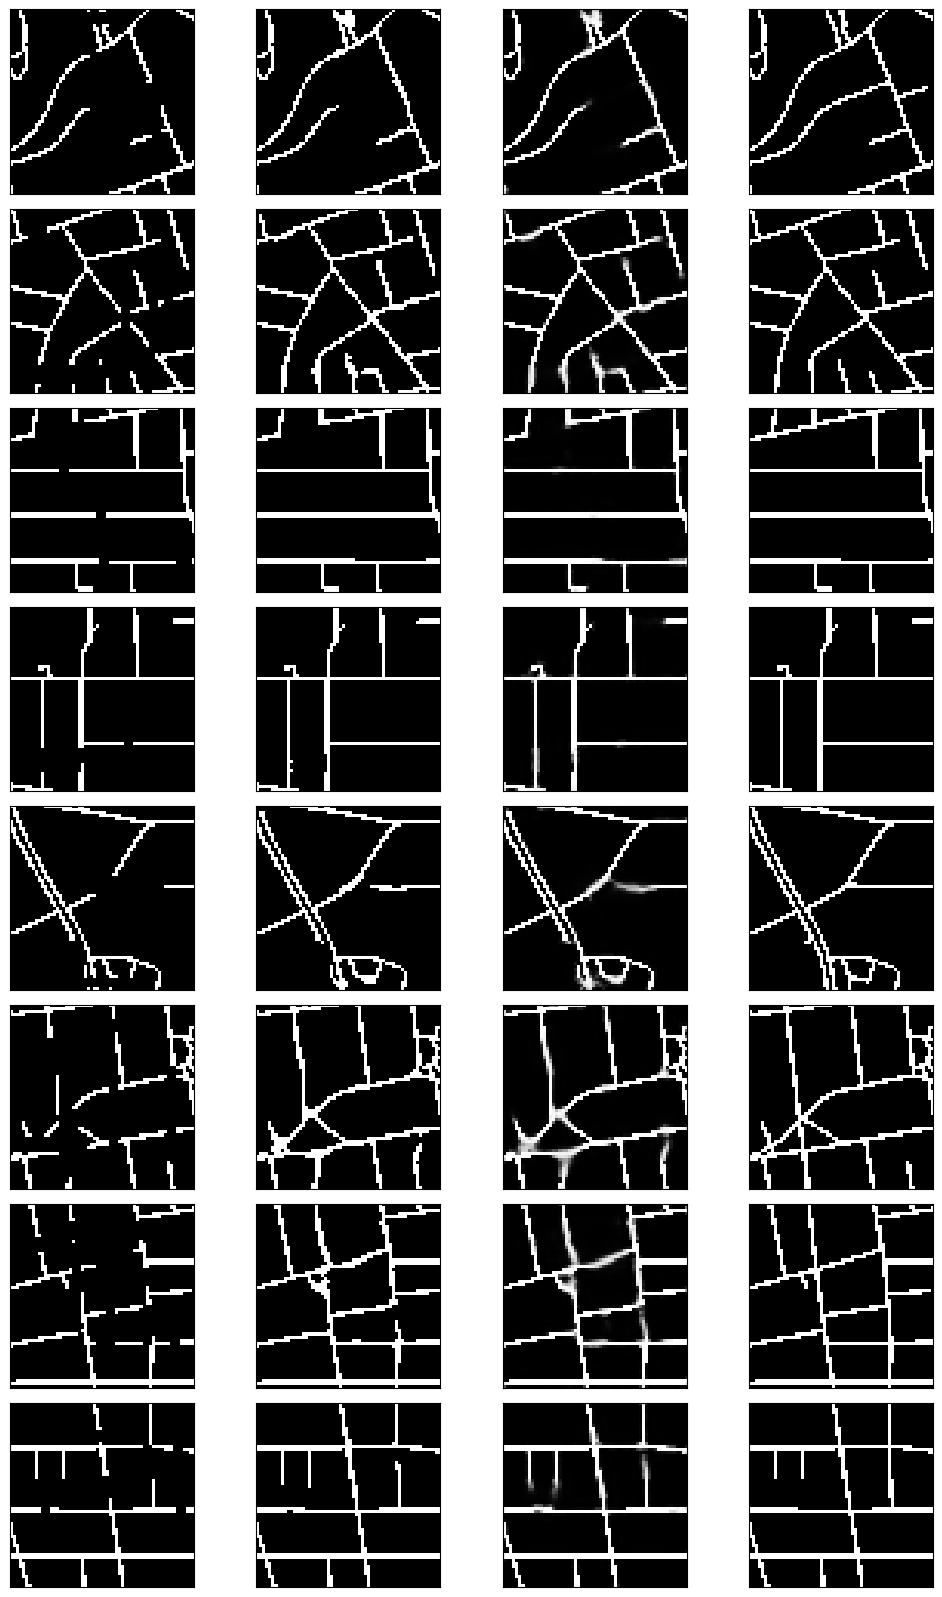

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = UNet()
net.load_state_dict(torch.load("models/unet_bce_1e-3_topo_1.pt", map_location=device))
results_unet_2, results_probs_unet_2 = evaluate_model(net, test_loader, device, start_ind=680)